<a href="https://colab.research.google.com/github/lIlIlIIIlIIl/Toy_Project/blob/main/100_class_VGG19_Classification_visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir results

###(사전 작업)kaggle.json 파일 다운로드 후 업로드

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d gpiosenka/sports-classification

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/sports-classification
License(s): CC0-1.0
 99% 420M/424M [00:14<00:00, 32.3MB/s]
100% 424M/424M [00:14<00:00, 30.2MB/s]


In [4]:
import zipfile
zip_file = zipfile.ZipFile('/content/sports-classification.zip') # 압축을 해제할 '/파일경로/파일명.zip'
zip_file.extractall('/content/sports-classification') # 압축을 해제할 '/위치경로/'

# Import

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os

#Dataset

In [6]:
# ===== transform 선언 ===== #
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# ===== 파일이 다운로드 된 경로 ===== #
data_folder = "/content/sports-classification"

train_folder = data_folder + "/train"
val_folder = data_folder + "/valid"
test_folder = data_folder + "/test"

trainset = datasets.ImageFolder(root=train_folder, transform=transform)
valset = datasets.ImageFolder(root=val_folder, transform=transform)
testset = datasets.ImageFolder(root=test_folder, transform=transform)

partition = {'train': trainset, 'val':valset, 'test':testset}


# Model Code

In [7]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

# CNN Model

In [8]:
class CNN(nn.Module):
    def __init__(self, model_code, in_channels, kernel_size, stride, out_dim, hid_dim, n_linear, act_func, use_bn, dropout):
        super(CNN, self).__init__()
        self.model_code = model_code
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.act_func = act_func
        self.use_bn = use_bn
        self.n_linear = n_linear
        self.Dropout = nn.Dropout(dropout)
        self.padding = self.kernel_size // 2
        self.data_size = 224 # 모듈화 필요


        if (32 - self.kernel_size + 2*self.padding)/self.stride + 1 != 32:
            raise ValueError('filter is not valid')


        if self.act_func == 'relu':
            self.act_func = nn.ReLU()

        elif self.act_func == 'tanh':
            self.act_func = nn.Tanh()

        elif self.act_func == 'sigmoid':
            self.act_func = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')

        self.layers = self._make_layers()
        self.classifier = self._make_fc_layers()

    def _make_layers(self):
        layers = [] # Sequential을 사용하기 위해 ModuleList가 아닌 그냥 List 사용
        for x in cfg[self.model_code]:
            if x == 'M':
                layers += [nn.MaxPool2d(2, 2)]
                self.data_size = self.data_size // 2 # 풀링 진행할 때마다 데이터 사이즈 절반으로 축소

            else:
                layers += [nn.Conv2d(self.in_channels, x, self.kernel_size, self.stride, self.padding)]
                if self.use_bn:
                    layers += [nn.BatchNorm2d(x)]
                layers += [self.act_func]
                self.in_channels = x # in_channels 업데이트

        self.in_channels = self.in_channels * self.data_size ** 2

        return nn.Sequential(*layers)
        # *layers: layers 리스트의 데이터들을 각각 받아주는 문법(가변 인수 느낌)
        # Sequential은 리스트를 받아서 하나의 서브모델을 만들어주는 문법. CNN모델 내의 layers모델을 서브모델로 만듦

    def _make_fc_layers(self):
        linears = []
        linears.append(nn.Linear(self.in_channels, self.hid_dim))
        for i in range(self.n_linear - 2):
            linears += [self.act_func, nn.Linear(self.hid_dim, self.hid_dim),self.Dropout]

        linears += [self.act_func, nn.Linear(self.hid_dim, self.out_dim),self.Dropout]
        return nn.Sequential(*linears)


    def forward(self, x):
        x = self.layers(x) # layers가 하나의 서브모델
        x = x.view(x.size(0), -1) # batch size는 그대로 유지하면서 3차원 tensor를 벡터 형태로 펼쳐준다.
        x = self.classifier(x)

        return x

## Dimenstion Check

In [ ]:
def dimension_check():
    net = CNN('VGG11', 3, 3, 1, 10, 4096, 3,'relu', True, 0)
    x = torch.randn(16, 3, 224, 224) # 해당 크기를 갖는 임의의 텐서를 생성
    y = net(x)
    print(y.size())

# layer를 쌓을 때마다 dimension이 맞는지 체크해주는 함수

dimension_check()

torch.Size([16, 10])


# ResNet

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
# out_planes는 곧 필터의 개수와 같다.
# stride는 1인 경우 사이즈가 유지되고, 2인 경우는 사이즈가 절반으로 줄어든다.

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                     bias=False)

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        # inplanes: 인풋 채널 수, planes: 필터 개수
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample # 초기 값과 최종 출력 값의 dimension이 달라진 경우 적용
        self.stride = stride

    def forward(self, x):
        identity = x  # 초기 x값을 미리 저장해둠

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x) # 초기 값과 출력 값의 차원이 맞지 않으면, 맞추어주는 작업을 한다.

        out += identity # 단순히 출력값과 identity를 더해주면 됨
        out = self.relu(out)

        return out

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion) # 필터 개수를 expansion만큼 늘려준다.
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Train

In [9]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                              batch_size=args.train_batch_size,
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다.

        # get the inputs
        inputs, labels = data
        # print(labels)
        # print(inputs.size()) # => (batchsize, channel, H, W) = (16, 3, 224, 224). 즉 dataloader가 4차원 텐서 형태로 데이터를 받아놓음; (shape쓰면 안됨)
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

# Validation

In [10]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'],
                                            batch_size=args.test_batch_size,
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

# Test

In [11]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'],
                                             batch_size=args.test_batch_size,
                                             shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [16]:
def eval(net,partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'],
                                             batch_size=args.test_batch_size,
                                             shuffle=False, num_workers=2)
    predict_label_list = []
    actual_label_list = []

    net.eval()
    for images, labels in testloader:

        for label in labels:
            label = label.item()
            actual_label_list.append(label)

        for image in images:
            with torch.inference_mode():
                image = image.cuda()
                # add batch_size and device
                image = image.unsqueeze(dim = 0)
                # logits
                logits = net(image)
                # lables
                label = torch.argmax(logits).item()
                predict_label_list.append(label)


    accuracy = accuracy_score(actual_label_list, predict_label_list)
    print(f"VGG19's accuracy: {accuracy*100}%")

    # get class names
    class_names = []

    data_folder_path = "/content/sports-classification/test"

    for name in sorted(os.listdir(data_folder_path)):
        class_names.append(name)


    matrix = confusion_matrix(actual_label_list,
                            predict_label_list
                            )

    plt.figure(figsize = (18, 18))
    plt.imshow(matrix, interpolation= "nearest", cmap = "GnBu")

    ticks = range(len(class_names))
    plt.xticks(ticks, class_names, rotation= 45)
    plt.yticks(ticks, class_names)
    plt.show()

# Experiment

In [12]:
def experiment(partition, args):

    net = CNN(args.model_code, args.in_channels, args.kernel_size, args.stride, args.out_dim, args.hid_dim, args.n_linear ,args.act_func, args.use_bn, args.dropout)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))


    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc

    eval(net, partition, args)
    return vars(args), result

In [13]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)


def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [14]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1"

# ====== Model Capacity ====== #
args.out_dim = 100
args.hid_dim = 512
args.n_linear = 2
args.act_func = 'relu'
args.model_code = 'VGG19'
args.in_channels = 3
args.kernel_size = 3
args.stride = 1

# ====== Regularization ======= #
args.l2 = 0.001
args.use_bn = True
args.dropout = 0.3

# ====== Optimizer & Training ====== #
args.optim = 'SGD' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.005
args.epoch = 20

args.train_batch_size = 32
args.test_batch_size = 32

print(args)
setting, result = experiment(partition, deepcopy(args))
save_exp_result(setting, result)

Namespace(exp_name='exp1', out_dim=100, hid_dim=512, n_linear=2, act_func='relu', model_code='VGG19', in_channels=3, kernel_size=3, stride=1, l2=0.001, use_bn=True, dropout=0.3, optim='SGD', lr=0.005, epoch=20, train_batch_size=32, test_batch_size=32)
Epoch 0, Acc(train/val): 6.66/15.20, Loss(train/val) 4.27/3.70. Took 256.71 sec
Epoch 1, Acc(train/val): 19.14/28.00, Loss(train/val) 3.57/2.96. Took 257.74 sec
Epoch 2, Acc(train/val): 28.33/31.20, Loss(train/val) 3.16/2.78. Took 257.37 sec
Epoch 3, Acc(train/val): 34.57/38.80, Loss(train/val) 2.89/2.45. Took 257.27 sec
Epoch 4, Acc(train/val): 39.93/47.60, Loss(train/val) 2.64/2.09. Took 257.19 sec
Epoch 5, Acc(train/val): 44.77/55.20, Loss(train/val) 2.43/1.93. Took 257.06 sec
Epoch 6, Acc(train/val): 48.67/49.40, Loss(train/val) 2.27/2.01. Took 257.18 sec
Epoch 7, Acc(train/val): 51.83/52.40, Loss(train/val) 2.10/1.74. Took 257.80 sec
Epoch 8, Acc(train/val): 55.68/58.60, Loss(train/val) 1.94/1.54. Took 257.47 sec
Epoch 9, Acc(train/v

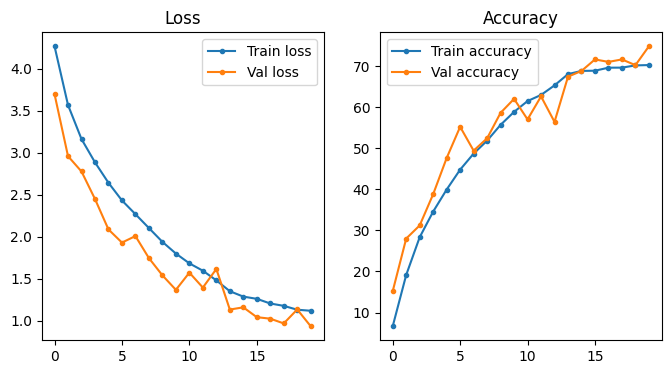

In [15]:
plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(result["train_losses"], label = "Train loss", marker='.')
plt.plot(result["val_losses"], label = "Val loss", marker='.')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(result["train_accs"], label = "Train accuracy", marker='.')
plt.plot(result["val_accs"], label = "Val accuracy", marker='.')
plt.legend()

VGG19's accuracy: 1.0%


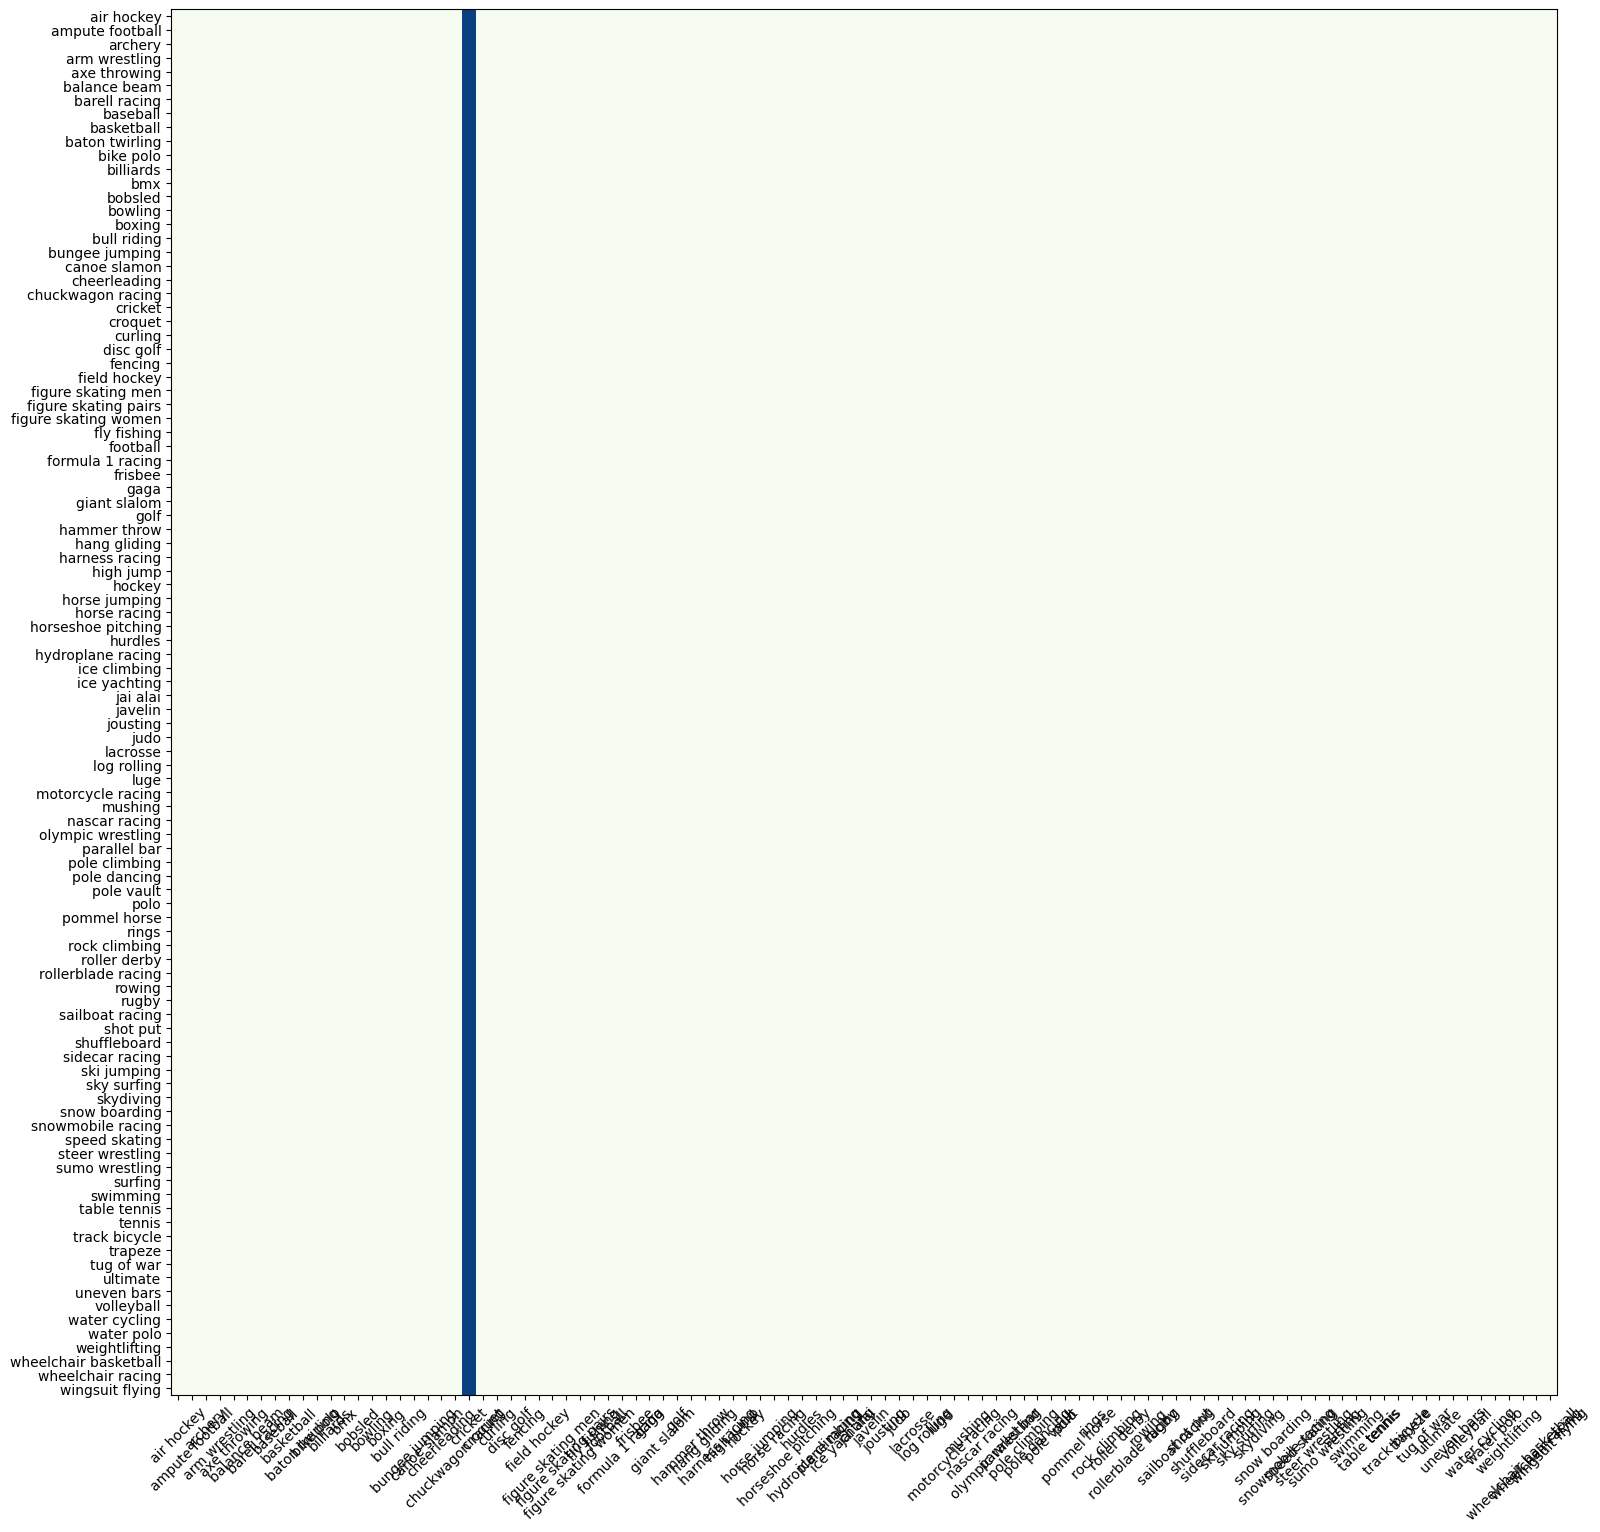

In [17]:
eval(partition, args)